In [1]:
from transformers import pipeline
import transformers
import pandas as pd
from tqdm import tqdm
from easynmt import EasyNMT
import warnings
warnings.filterwarnings('ignore')

# reload automatically notebook
%load_ext autoreload
%autoreload 2

# transofrmer warnigns off
transformers.logging.set_verbosity_error()



In [2]:
ESG_DICT = {
    "environnemental": ["changement climatique", "capital naturel", "pollution et déchets", "Opportunités environnementales"],
    "social": ["capital humain", "responsabilité du produit", "opposition des parties prenantes", "opportunités sociales", "services publiques"],
    "gouvernance": ["gouvernance d'entreprises", "comportement d'entreprises"],
    "non-esg": ["autre","divertissement"]
}

CANDIDATE_LABELS = list(ESG_DICT.values())
CANDIDATE_LABELS = [item for sublist in CANDIDATE_LABELS for item in sublist]


cb_base = pipeline("zero-shot-classification", model="camembert-base")
cb_large = pipeline("zero-shot-classification", model="camembert/camembert-large")
mDeBert_base = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli")

mDeBert_en = pipeline("zero-shot-classification", model="MoritzLaurer/deberta-v3-large-zeroshot-v1.1-all-33")
translator_model = EasyNMT('opus-mt',cache_folder="./NMT_model_cache")


# test_data = pd.read_csv("../data/final_test_esg2.csv")
# test_data.esg_category.unique()


In [3]:
test_data_raw = pd.read_csv("../../datasets/final_dataset/esg_fr.csv")
# extract only columns text_en and esg_category
test_data_en = test_data_raw[["text_en","text_fr", "esg_category"]]

# remove rows with nan in text_en
test_data_en = test_data_en.dropna(subset=["text_en"])

test_data = pd.concat(
    [
        test_data_en[test_data_en["esg_category"] == "environmental"].sample(150, random_state=42),
        test_data_en[test_data_en["esg_category"] == "social"].sample(150, random_state=42),
        test_data_en[test_data_en["esg_category"] == "governance"].sample(150, random_state=42),
        test_data_en[test_data_en["esg_category"] == "non-esg"].sample(150, random_state=42)
    ]
)

In [4]:
def translate(text:str, model)->str:
    return model.translate(text, source_lang="fr", target_lang="en")

def predict_sample(sample, model,  candidate_labels, top_k = 3, return_all = False, translate_input = False):
    if translate_input: 
        translated_sample = translate(sample, translator_model)
        output = model(translated_sample, candidate_labels, multi_label=False)
    else: output = model(sample, candidate_labels, multi_label=False)
    
    output_df = pd.DataFrame(output)[["labels", "scores"]][:top_k]
    # find the key from the esg_dict
    output_df["key_label"] = output_df["labels"].apply(lambda x: [key for key, value in ESG_DICT.items() if x in value][0])
    
    count_dict = {}
    for label in output_df["key_label"]:
        count_dict[label] = count_dict.get(label, 0) + 1

    best_choice = max(count_dict, key=count_dict.get)
    
    if return_all: return output_df, best_choice
    
    return best_choice

def predict_df(df,model,candidate_labels, text_column = "text", output_label_column = "esg_predictor", translate_input=False):
    # df['esg_predictor'] = df[text_column].apply(self.predict)
    tqdm.pandas(desc=f"Predicting ...")
    df[output_label_column] = df[text_column].progress_apply(predict_sample, model=model, candidate_labels=candidate_labels, translate_input=translate_input)
    return df



In [5]:
df_res = predict_df(test_data, model=cb_base, candidate_labels=CANDIDATE_LABELS, output_label_column="cb_base_pred",text_column="text_fr")
df_res = predict_df(df_res, model=cb_large, candidate_labels=CANDIDATE_LABELS, output_label_column="cb_large_pred",text_column="text_fr")
# df_res = predict_df(df_res, model=mDeBert_base, candidate_labels=CANDIDATE_LABELS, output_label_column="mDeBert_base_pred",text_column="text_fr")
df_res = predict_df(df_res, model=mDeBert_en, candidate_labels=CANDIDATE_LABELS, output_label_column="mDeBert_en_pred", text_column="text_en")


Predicting ...: 100%|██████████| 600/600 [2:09:12<00:00, 12.92s/it]  


In [4]:
df_res = pd.read_csv("./baseline_results.csv")
print(df_res.esg_category.unique())
# replace environmental with environnemental
df_res.esg_category = df_res.esg_category.replace("environmental", "environnemental")
df_res.esg_category = df_res.esg_category.replace("governance", "gouvernance")

# classification report for cb_base_pred and cb_large_pred
from sklearn.metrics import classification_report
print("Classification report for cb_base_pred")
print(classification_report(df_res.esg_category, df_res.cb_base_pred, zero_division=0))
print("Classification report for cb_large_pred")
print(classification_report(df_res.esg_category, df_res.cb_large_pred, zero_division=0))
print("Classification report for mDeBert_base_pred")
# print(classification_report(df_res.esg_category, df_res.mDeBert_base_pred))
print("Classification report for mDeBert_en_pred")
print(classification_report(df_res.esg_category, df_res.mDeBert_en_pred))


['environmental' 'social' 'governance' 'non-esg']
Classification report for cb_base_pred
                 precision    recall  f1-score   support

environnemental       0.25      0.89      0.39       150
    gouvernance       0.38      0.09      0.14       150
        non-esg       0.33      0.01      0.01       150
         social       0.26      0.04      0.07       150

       accuracy                           0.26       600
      macro avg       0.31      0.26      0.15       600
   weighted avg       0.31      0.26      0.15       600

Classification report for cb_large_pred
                 precision    recall  f1-score   support

environnemental       0.29      0.35      0.32       150
    gouvernance       0.27      0.33      0.30       150
        non-esg       0.27      0.22      0.24       150
         social       0.33      0.27      0.30       150

       accuracy                           0.29       600
      macro avg       0.29      0.29      0.29       600
   weighted

# Logistic regression with TF-IDF

In [22]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


data = pd.read_csv("../data/esg_fr_classification.csv")
print(data.head())
print(data.describe())

print(data.shape)


                                                text     esg_category
0  Les niveaux de dioxyde de carbone intérieur po...  environnemental
1  Le prix de l'électricité est déroutant sanglan...  environnemental
2  La migration de masse n'est pas une crise: c'e...  environnemental
3  La rupture du climat arrive. Le Royaume-Uni a ...  environnemental
4  Le changement climatique forçant déjà les oise...  environnemental
                                                     text     esg_category
count                                               16986            16986
unique                                              16802                4
top     Les travailleurs du BHS partagent un paiement ...  environnemental
freq                                                    4             4428
(16986, 2)


Epoch 1/15, Loss: 0.49407856976296854
Epoch 2/15, Loss: 0.490616788934252
Epoch 3/15, Loss: 0.48984334662247664
Epoch 4/15, Loss: 0.48951731928563086
Epoch 5/15, Loss: 0.4893609424681392
Epoch 6/15, Loss: 0.4892845456010279
Epoch 7/15, Loss: 0.48924703962829214
Epoch 8/15, Loss: 0.4892285704657351
Epoch 9/15, Loss: 0.4892194518281667
Epoch 10/15, Loss: 0.4892149390522156
Epoch 11/15, Loss: 0.48921270084112856
Epoch 12/15, Loss: 0.48921158853625474
Epoch 13/15, Loss: 0.4892110347503988
Epoch 14/15, Loss: 0.48921075857122237
Epoch 15/15, Loss: 0.48921062062433784
Accuracy: 0.8293113596233078
Classification Report:
                  precision    recall  f1-score   support

environnemental       0.96      0.88      0.92       865
    gouvernance       0.88      0.87      0.88       833
        non-esg       0.70      0.81      0.75       860
         social       0.81      0.76      0.78       840

       accuracy                           0.83      3398
      macro avg       0.84      0.8

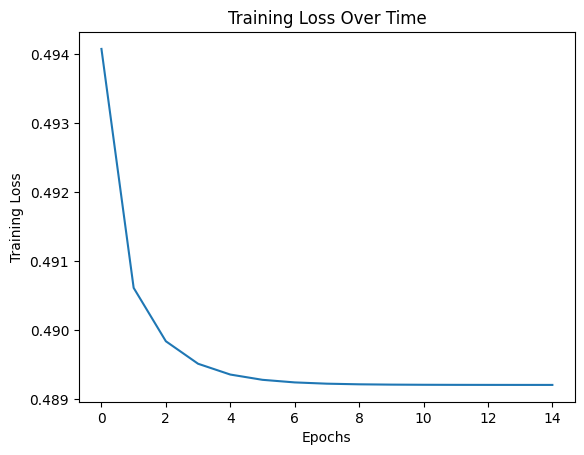

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
# improt log_loss
from sklearn.metrics import log_loss


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['esg_category'], test_size=0.2, random_state=42)

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# SGDClassifier for logistic regression with loss tracking
clf = SGDClassifier(loss='log_loss', max_iter=1, tol=None, random_state=42, warm_start=True, early_stopping=True, n_iter_no_change=5, validation_fraction=0.2)

# Training the model and capturing the loss
training_losses = []

def monitor_loss(sgd_classifier, X, y, epochs):
    for i in range(epochs):
        sgd_classifier.fit(X, y)
        y_proba = sgd_classifier.predict_proba(X)
        loss = log_loss(y, y_proba)
        training_losses.append(loss)
        print(f"Epoch {i+1}/{epochs}, Loss: {loss}")

# Using custom function to monitor loss
monitor_loss(clf, X_train_tfidf, y_train, epochs=15)

# Predict on test data
y_pred = clf.predict(X_test_tfidf)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plotting the training loss
plt.plot(training_losses)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Time')
plt.show()

In [20]:
test_data = pd.read_csv("../data/final_test_esg2.csv")
y_pred = clf.predict(tfidf.transform(test_data['text']))
print("Accuracy:", accuracy_score(test_data['esg_category'], y_pred))
print("Classification Report:\n", classification_report(test_data['esg_category'], y_pred))

Accuracy: 0.6197183098591549
Classification Report:
                  precision    recall  f1-score   support

environnemental       0.75      0.50      0.60        18
    gouvernance       0.71      0.71      0.71        14
        non-esg       0.50      0.79      0.61        19
         social       0.67      0.50      0.57        20

       accuracy                           0.62        71
      macro avg       0.66      0.63      0.62        71
   weighted avg       0.65      0.62      0.62        71

